# 0.0 IMPORTS

In [174]:
import math
import numpy as np
import random
import pickle
import warnings
import pandas as pd 
import inflection
import seaborn as sns



from scipy                 import stats as ss
from matplotlib            import pyplot as plt
from IPython.core.display  import HTML
from IPython.display       import Image 
from IPython.core.display  import HTML

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error,mean_squared_error
from sklearn.linear_model  import LinearRegression , Lasso
from sklearn.ensemble      import RandomForestRegressor

warnings.filterwarnings("ignore")


## 0.1. Helper Functions

In [170]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range( 1,kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ))

        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[( x_training['date'] >= validation_start_date ) & ( x_training['date'] <= validation_end_date )]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date','sales'], axis=1 )
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date','sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining)

        # prediction
        yhat = m.predict( xvalidation)

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean( mae_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( mae_list ), 2 ).astype(str),
                         'MAPE CV': np.round(np.mean( mape_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( mape_list ), 2 ).astype(str),
                         'RMSE CV': np.round(np.mean( rmse_list ), 2 ).astype( str) + ' +/- ' + np.round(np.std( rmse_list ), 2 ).astype(str)}, index=[0])

def mean_absolute_percentage_error( y, yhat):
    return np.mean(np.abs(y - yhat) / y)

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error( y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt( mean_squared_error( y,yhat) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

def cramer_v( x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0 , chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
   
    return np.sqrt( (chi2corr/n) / (min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()


In [171]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\USUARIO\anaconda3\envs\Rossman_Sales_Model\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [5]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
604571,1027,1,2014-01-06,0,0,0,1,a,0,a,c,190.00,6.00,2008.00,1,40.00,2011.00,"Jan,Apr,Jul,Oct"


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

## 1.1. Rename Columns

In [6]:
df1 = df_raw.copy()

In [7]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
664368,614,3,2013-11-13,5148,782,1,0,0,0,a,a,1160.00,12.00,2012.00,0,NaN,NaN,NaN
673185,511,2,2013-11-05,6191,873,1,1,0,0,a,a,2060.00,9.00,2009.00,0,NaN,NaN,NaN
817429,920,6,2013-06-29,5706,507,1,0,0,0,a,a,850.00,2.00,2012.00,1,40.00,2014.00,"Jan,Apr,Jul,Oct"
999766,397,3,2013-01-16,2795,457,1,0,0,0,a,c,130.00,NaN,NaN,1,27.00,2013.00,"Feb,May,Aug,Nov"
31513,294,5,2015-07-03,6125,773,1,1,0,0,a,a,3150.00,5.00,2005.00,0,NaN,NaN,NaN


In [8]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [9]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list (map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [10]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [11]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print ('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [12]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [13]:
# alterando formato date
df1['date'] = pd.to_datetime(df1['date'])

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [16]:
df1['competition_distance'].max()

75860.0

In [17]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
40627,488,4,2015-06-25,3116,319,1,0,0,0,a,c,2890.00,4.00,2014.00,0,NaN,NaN,NaN


In [18]:
#competition_distance(distância em metros da loja que faz competição mais próxima)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

In [19]:
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

In [20]:
#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)                                                                                                                       

In [21]:
#promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

In [22]:
#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [23]:
#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [24]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [25]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [26]:
# substituindo tipo - competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# substituindo tipo - promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistical

In [27]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [28]:
# Análise Univariada
# Central Tendency - mean, median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)). T
ct2 = pd.DataFrame (num_attributes.apply(np.median)). T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min) ).T
d3 = pd.DataFrame(num_attributes.apply(max) ).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [29]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.00,1115.00,1115.00,558.43,558.00,321.91,-0.00,-1.20
1,day_of_week,1.00,7.00,7.00,4.00,4.00,2.00,0.00,-1.25
2,sales,0.00,41551.00,41551.00,5773.82,5744.00,3849.92,0.64,1.78
3,customers,0.00,7388.00,7388.00,633.15,609.00,464.41,1.60,7.09
4,open,0.00,1.00,1.00,0.83,1.00,0.38,-1.76,1.09
5,promo,0.00,1.00,1.00,0.38,0.00,0.49,0.49,-1.76
6,school_holiday,0.00,1.00,1.00,0.18,0.00,0.38,1.68,0.82
7,competition_distance,20.00,200000.00,200000.00,5935.44,2330.00,12547.65,10.24,147.79
8,promo2,0.00,1.00,1.00,0.50,1.00,0.50,-0.00,-2.00
9,is_promo,0.00,1.00,1.00,0.16,0.00,0.36,1.90,1.63


In [30]:
df1 = df1[df1['competition_distance'] < df1['competition_distance'].quantile(0.95)] 

C:\Users\USUARIO\anaconda3\envs\Rossman_Sales_Model\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

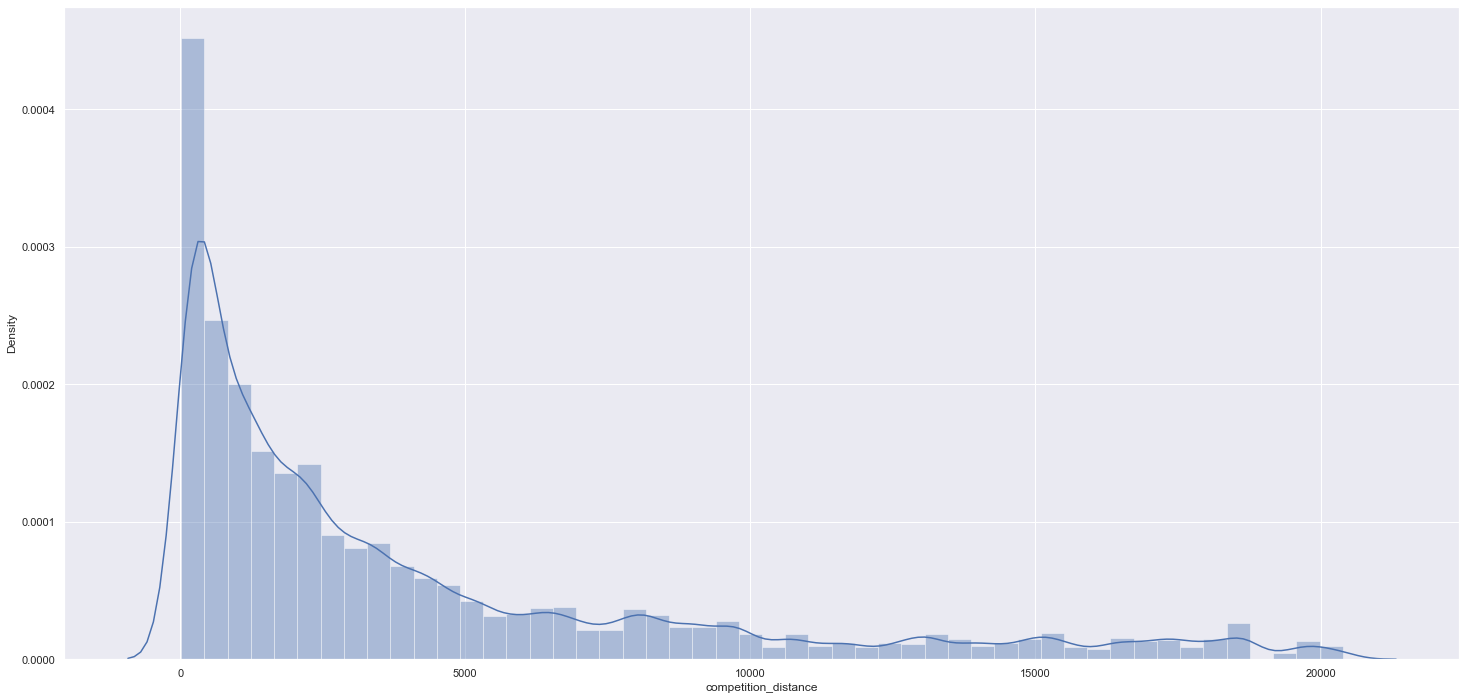

In [31]:
sns.distplot(df1['competition_distance'])

## 1.7.1 Categorical Attributes

In [32]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

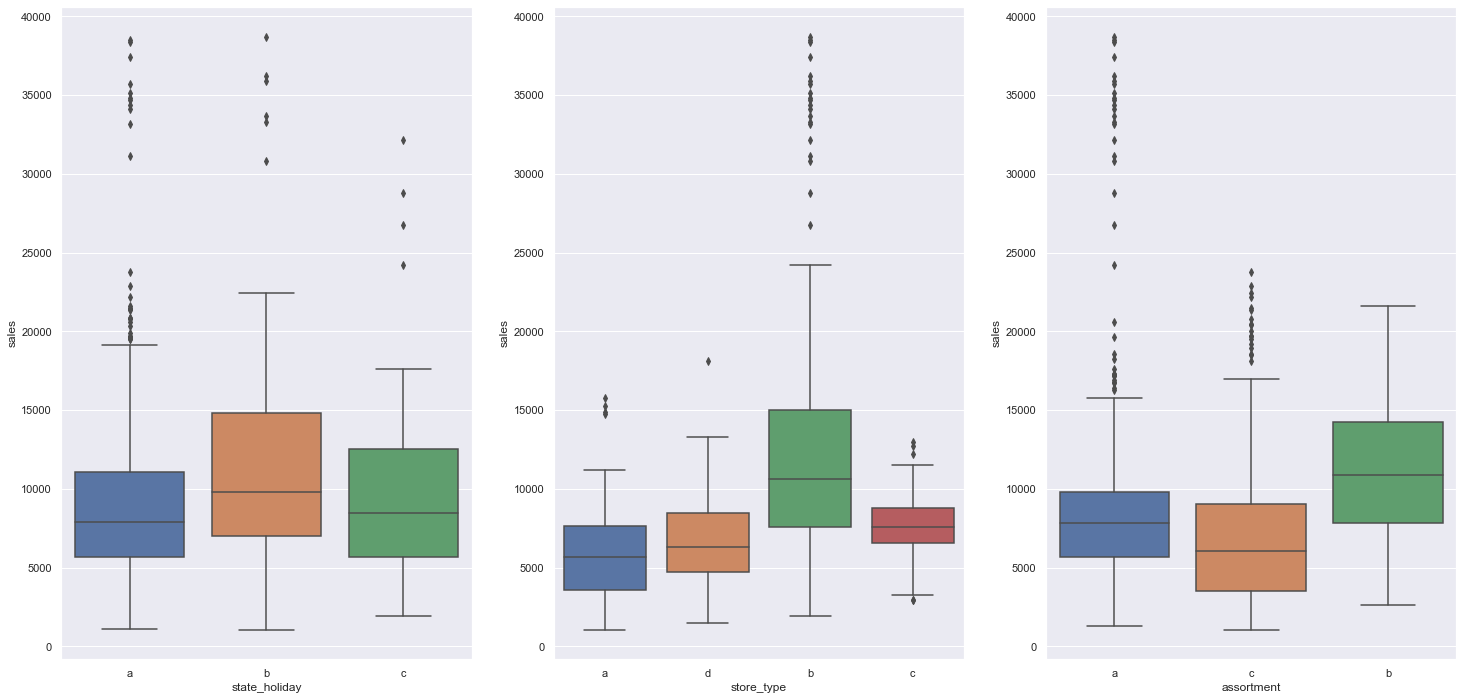

In [33]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )

sns.boxplot( x='assortment', y='sales', data=aux )

In [34]:
df2 = df1.copy()

## 2.0. Mapa Mental de Hipoteses

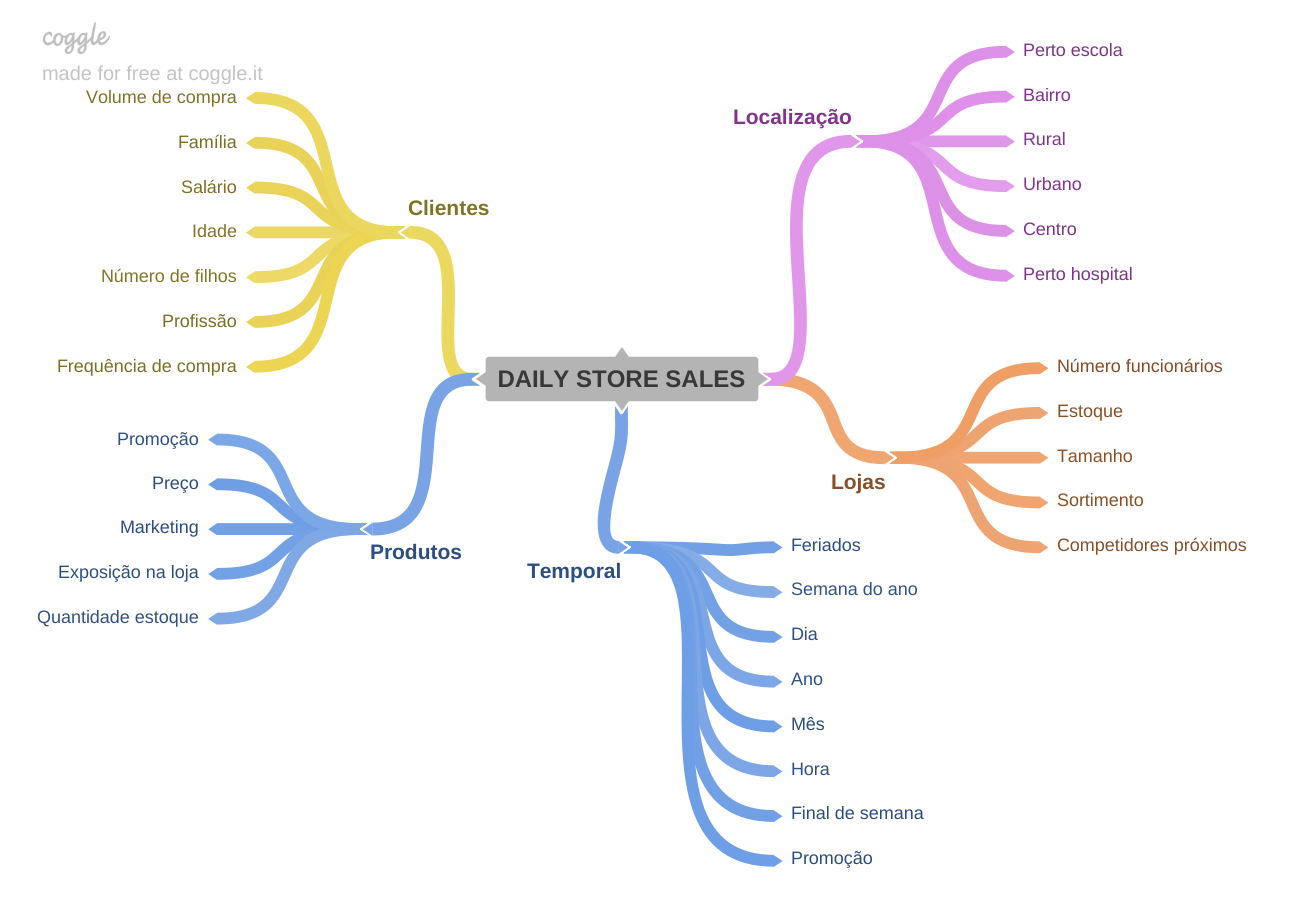

In [35]:
Image('images/MidMapHipoteses.png')

## 2.1. Criação das Hipoteses

### 2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender mais.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojass com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.


### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender mais.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [36]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime (year=x ['competition_open_since_year'],
                                                                   month=x['competition_open_since_month'],
                                                                   day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )


# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday 
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' 
                                                                              else 'easter_holiday' if x == 'b' 
                                                                              else 'christmas' if x == 'c' 
                                                                              else 'regular_day' )

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_8696\3312173254.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [37]:
df2.head(20).T

,0,1,2,3,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
store,1,2,3,4,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
day_of_week,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,5651,8492,8565,7185,10457,8959,8821,6544,9191,10231,8430,10071,8234,9593,9515,6566
customers,555,625,821,1498,589,833,687,681,1236,962,568,710,766,979,946,936,718,974,682,633
open,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
promo,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,0
store_type,c,a,a,c,a,a,a,a,a,a,d,a,d,a,a,d,a,d,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [38]:
df3 = df2.copy()

In [39]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.00,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.00,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.00,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.00,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
5,6,5,2015-07-31,5651,589,1,1,regular_day,1,a,basic,310.00,12,2013,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0


## 3.1. Filtragem das Linhas

In [40]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [41]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [42]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [43]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

C:\Users\USUARIO\anaconda3\envs\Rossman_Sales_Model\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

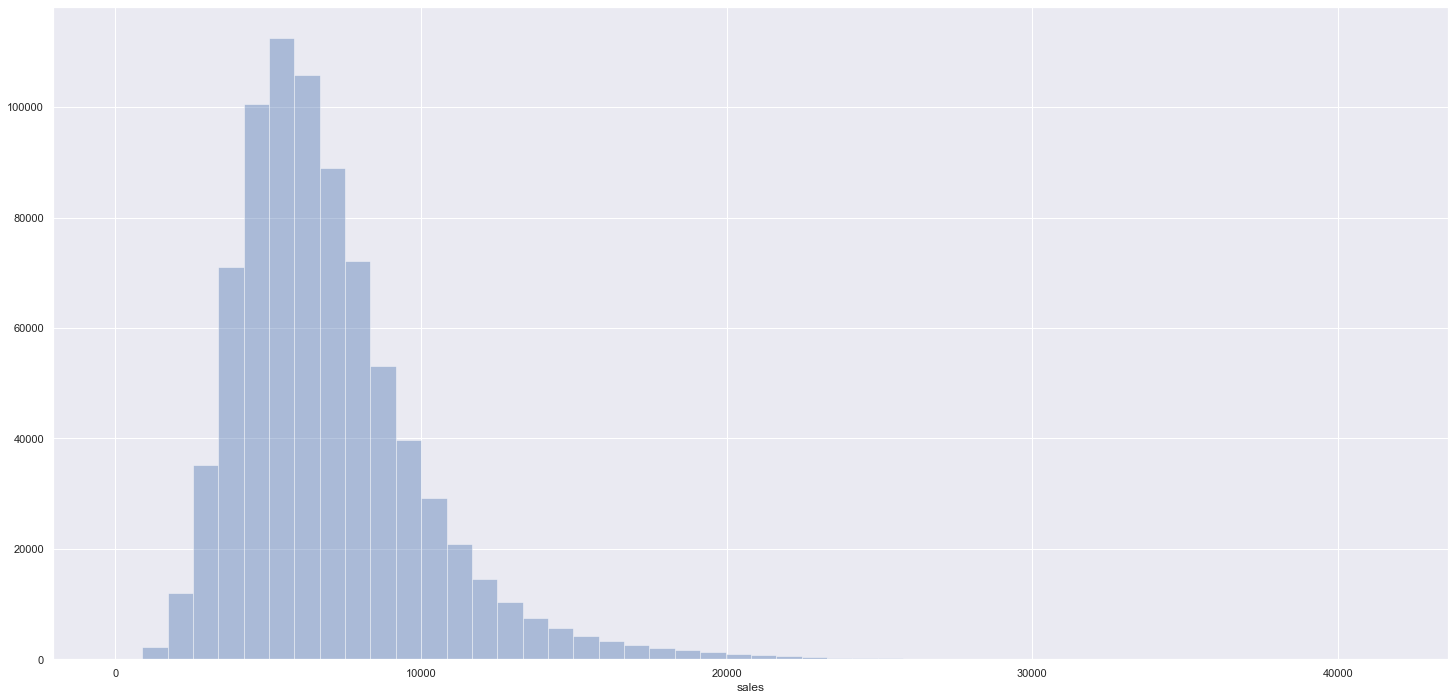

In [44]:
sns.distplot(df4['sales'],kde=False)

### 4.1.1. Numerical Variable

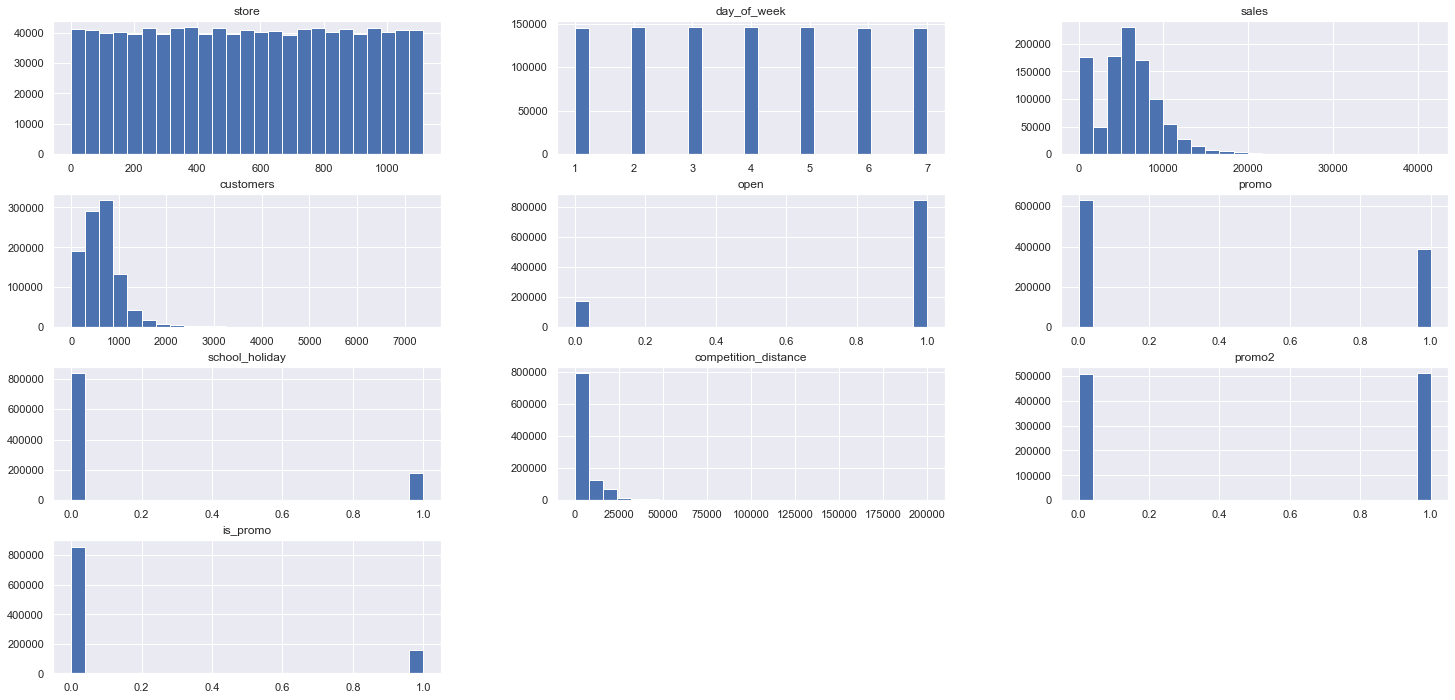

In [45]:
num_attributes.hist(bins=25);


In [46]:
# day_of_week:  O dia da semana interfere minimamente no volume de vendas
# customers: Há uma kurtosis e um skew positivo.A quantidade de customers não influencia proporcionalmente o volume de vendas
# promo: Há maior volume de vendas quando não há promo
# school_holiday: Volume de vendas é maior quando não há school holiday
# competition_distance: Há uma kurtosis e um skew positivo. Os competidores estão muito próximos
# competition_open_since_month: Há um comportamento de subida de decréscimo constante
# competition_open_since_year: Há uma kurtosis e um skew negativo.
# promo2: Volume de vendas praticamente igual entre os dois indicadores
# promo2_since_week: Há muitas variações ao longo das semanas
# promo2_since_year:  Houve um pico nos anos de 2013 e 2014
# is_promo: Volume de vendas maior quando não há promo

### 4.1.1. Categorical Variable

In [47]:
cat_attributes.head()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
0,0,c,a,9,2008,31,2015,0,Jul
1,0,a,a,11,2007,13,2010,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,12,2006,14,2011,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,9,2009,31,2015,0,Jul
4,0,a,a,4,2015,31,2015,0,Jul


In [48]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\USUARIO\anaconda3\envs\Rossman_Sales_Model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\USUARIO\anaconda3\envs\Rossman_Sales_Model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\USUARIO\anaconda3\envs\Rossman_Sales_Model\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

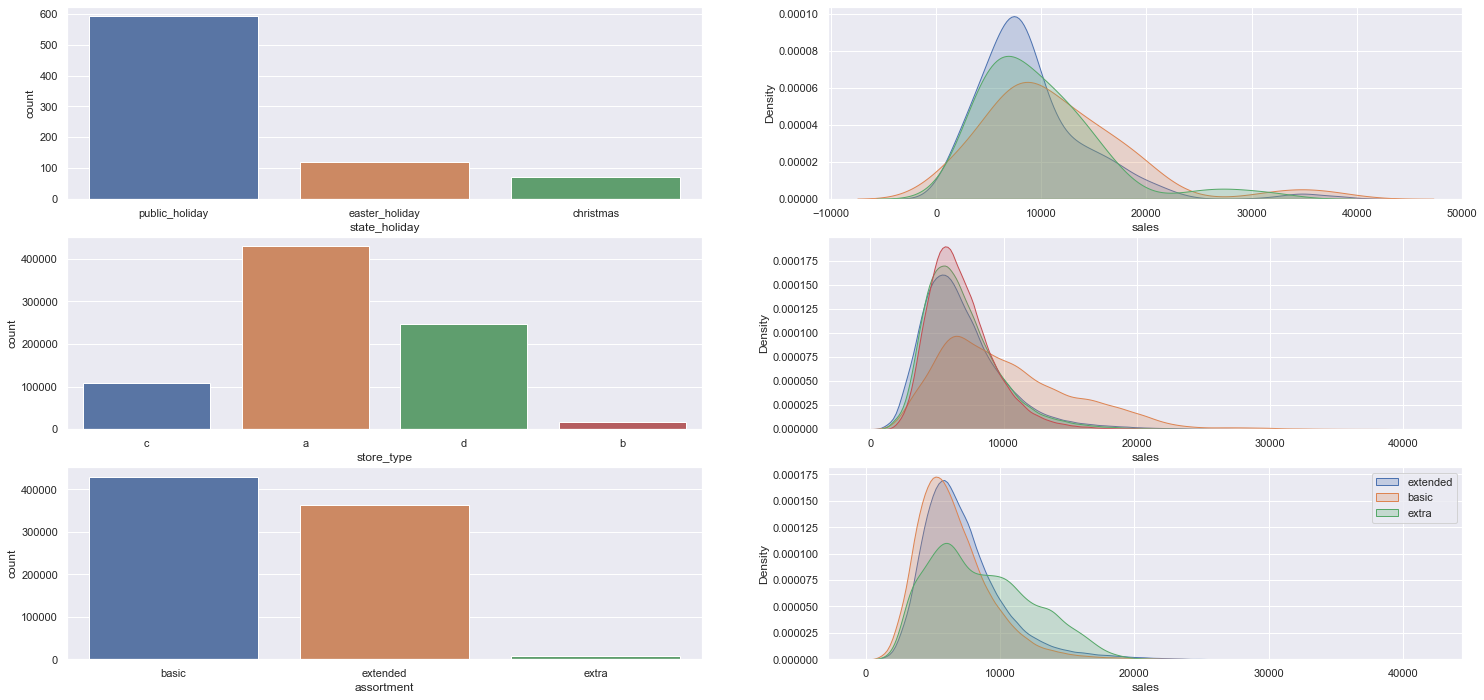

In [49]:
# state_holiday
plt.subplot(3,2,1)
a = df4 [df4['state_holiday'] != 'regular_day']
sns.countplot (a['state_holiday'])

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True )

# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c',shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d',shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True)
plt.legend()

## 4.2. Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais. 
**FALSA** Lojas com MAIOR SORTIMENTO vender MENOS.

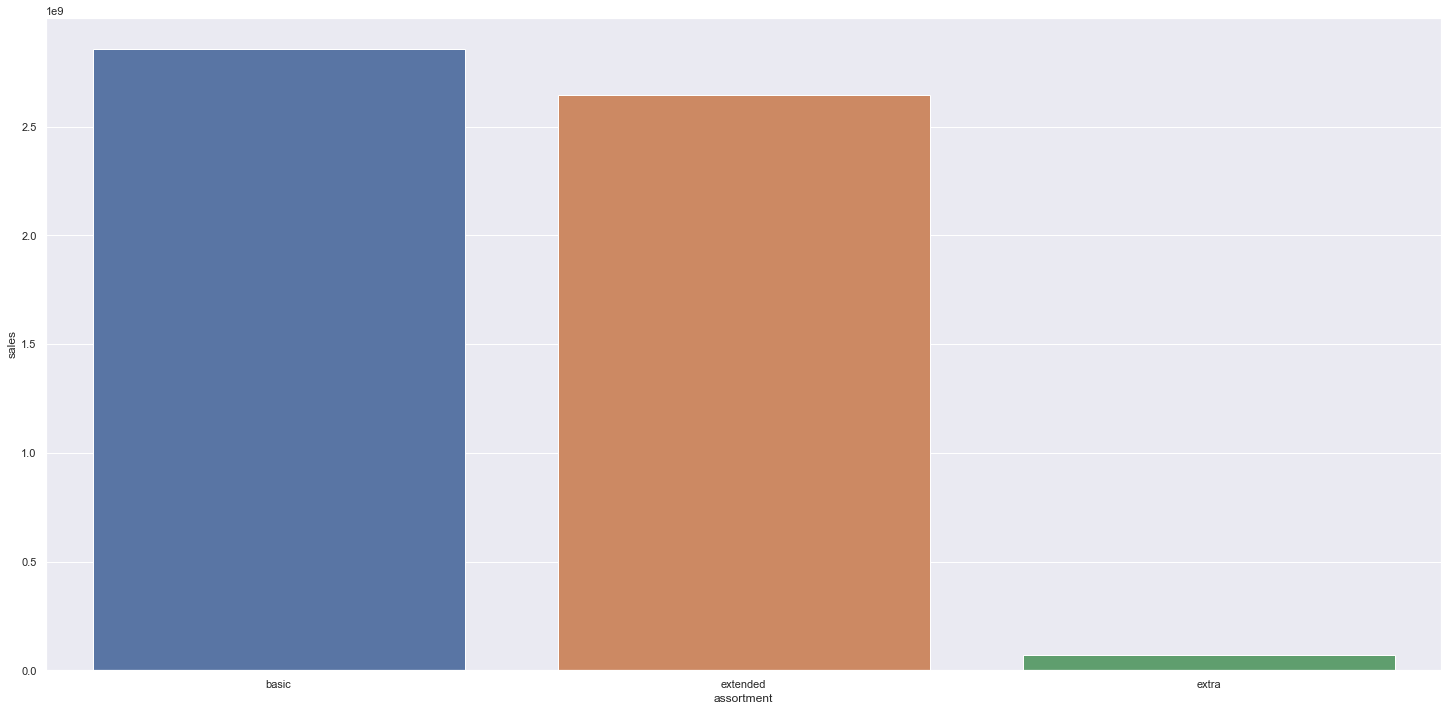

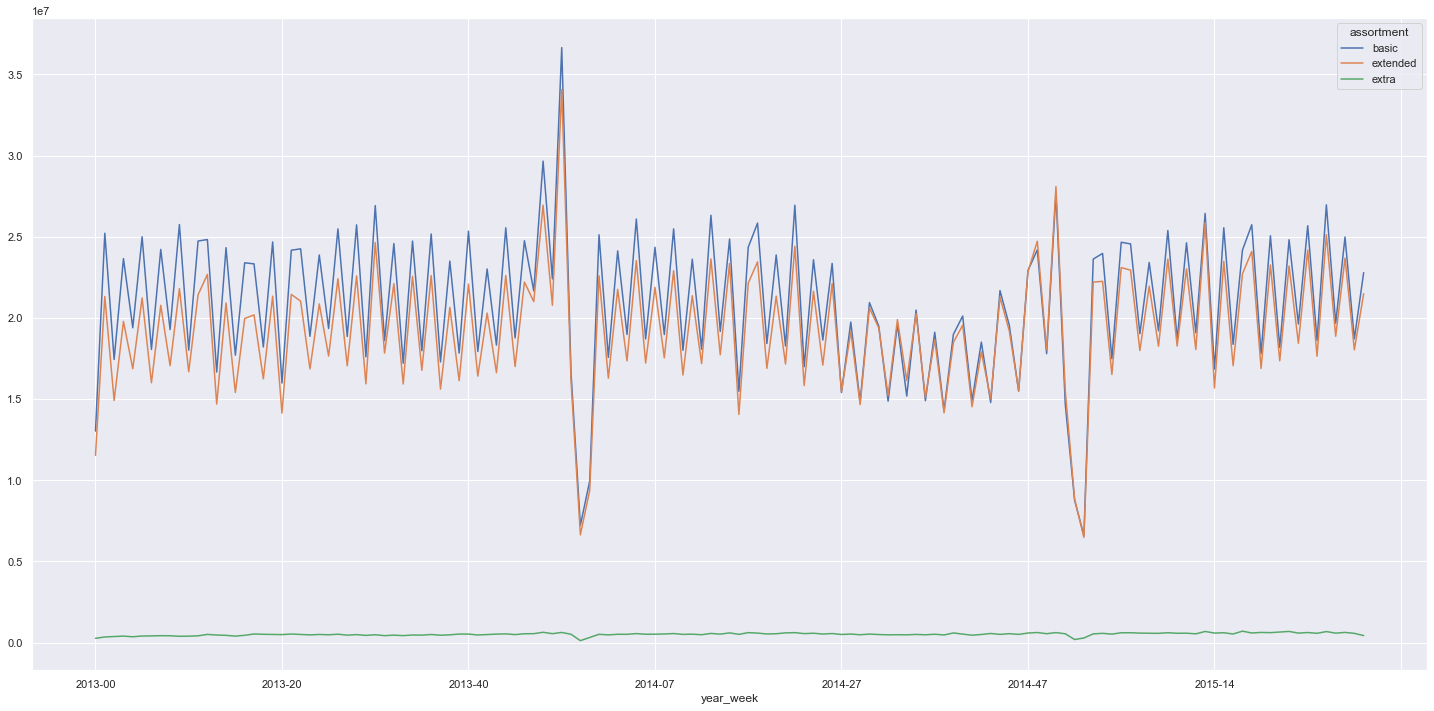

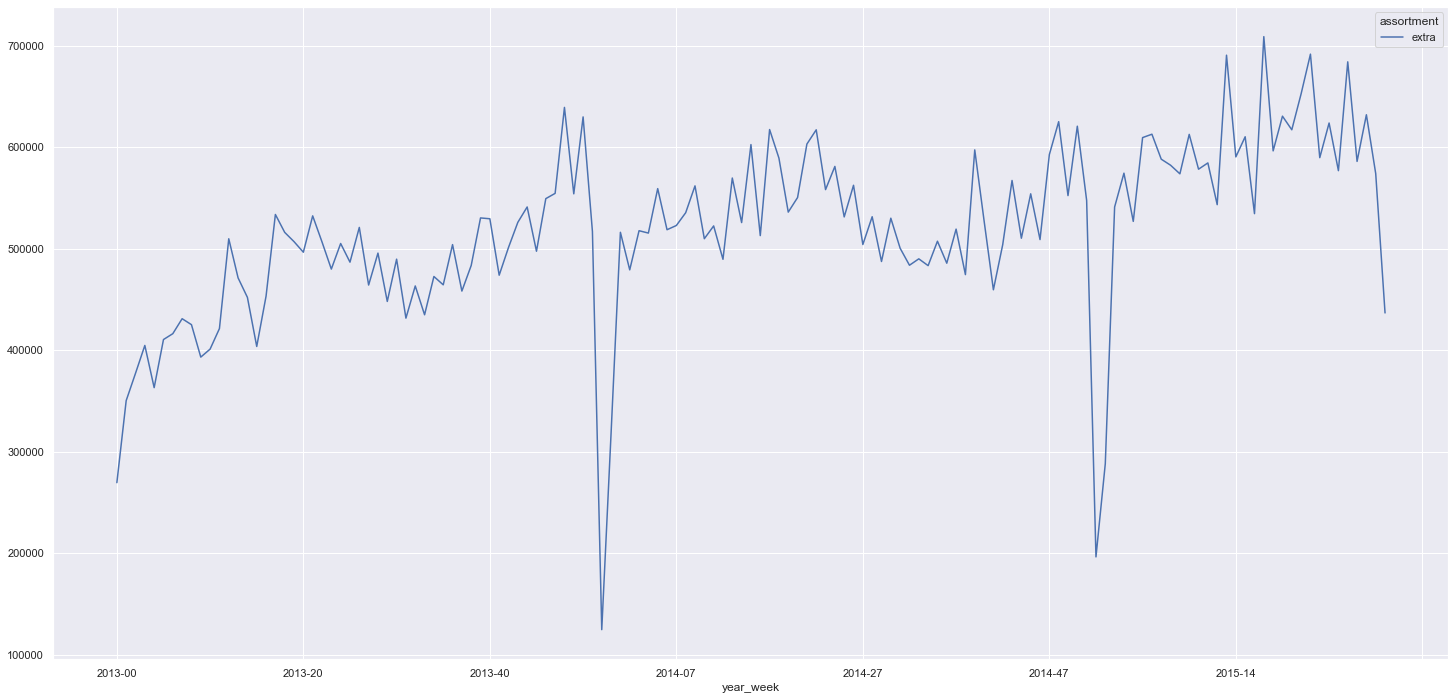

In [50]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index= 'year_week',columns= 'assortment',values='sales').plot();

In [51]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13030280
1,2013-00,extended,11538098
2,2013-00,extra,269404
3,2013-01,basic,25214114
4,2013-01,extended,21318071


### H2.Lojas com competidores mais próximos deveriam vender menos.
**Falsa** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem mais.

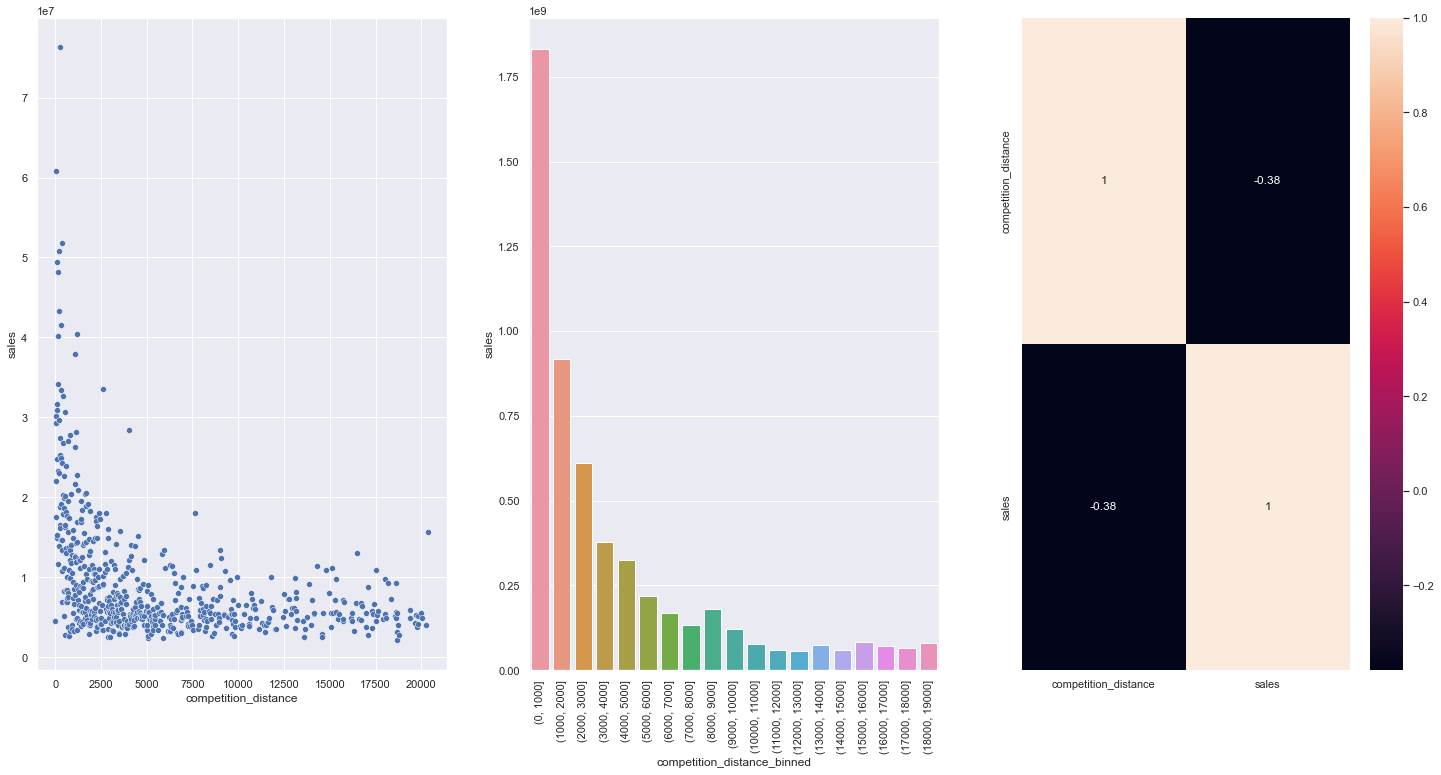

In [52]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

plt.subplot(1,3,2)
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3.Lojas com competidores à mais tempo deveriam vender mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

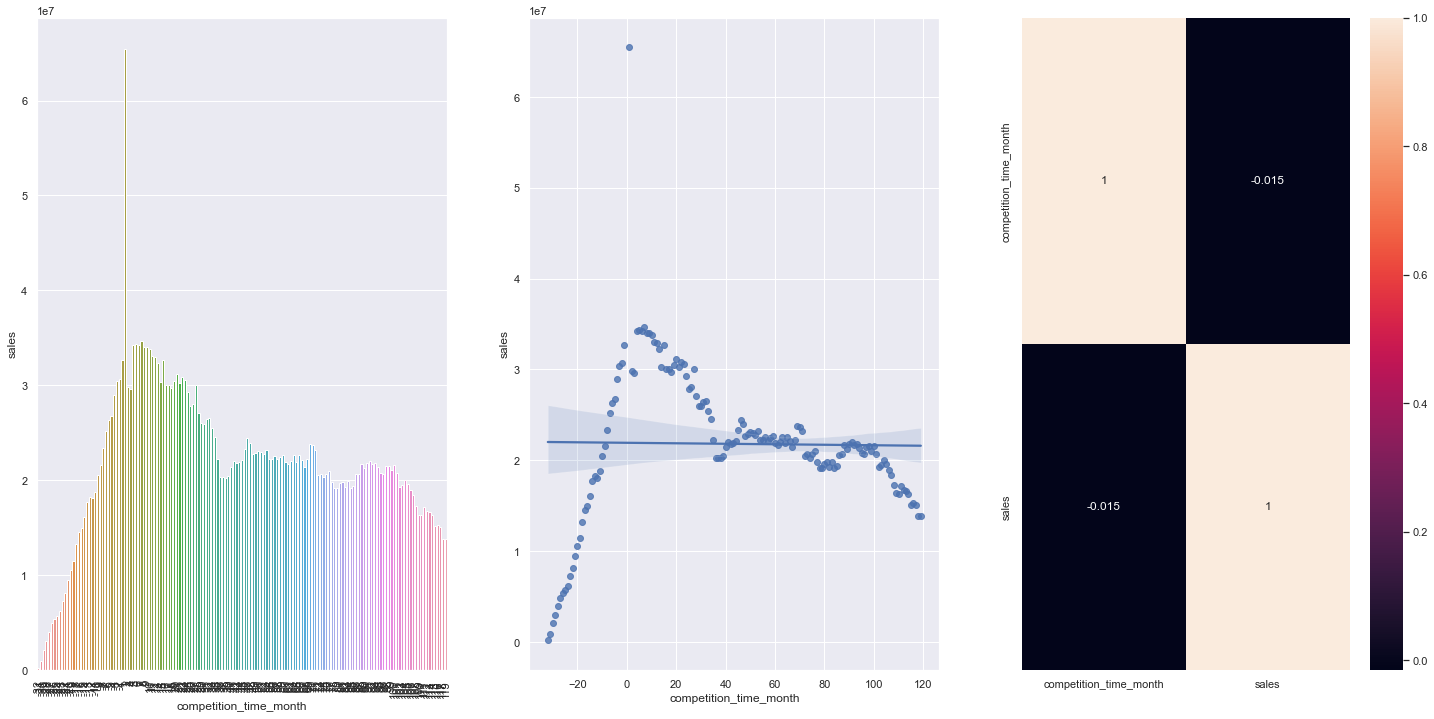

In [53]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]


plt.subplot(1,3,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

### H4.Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

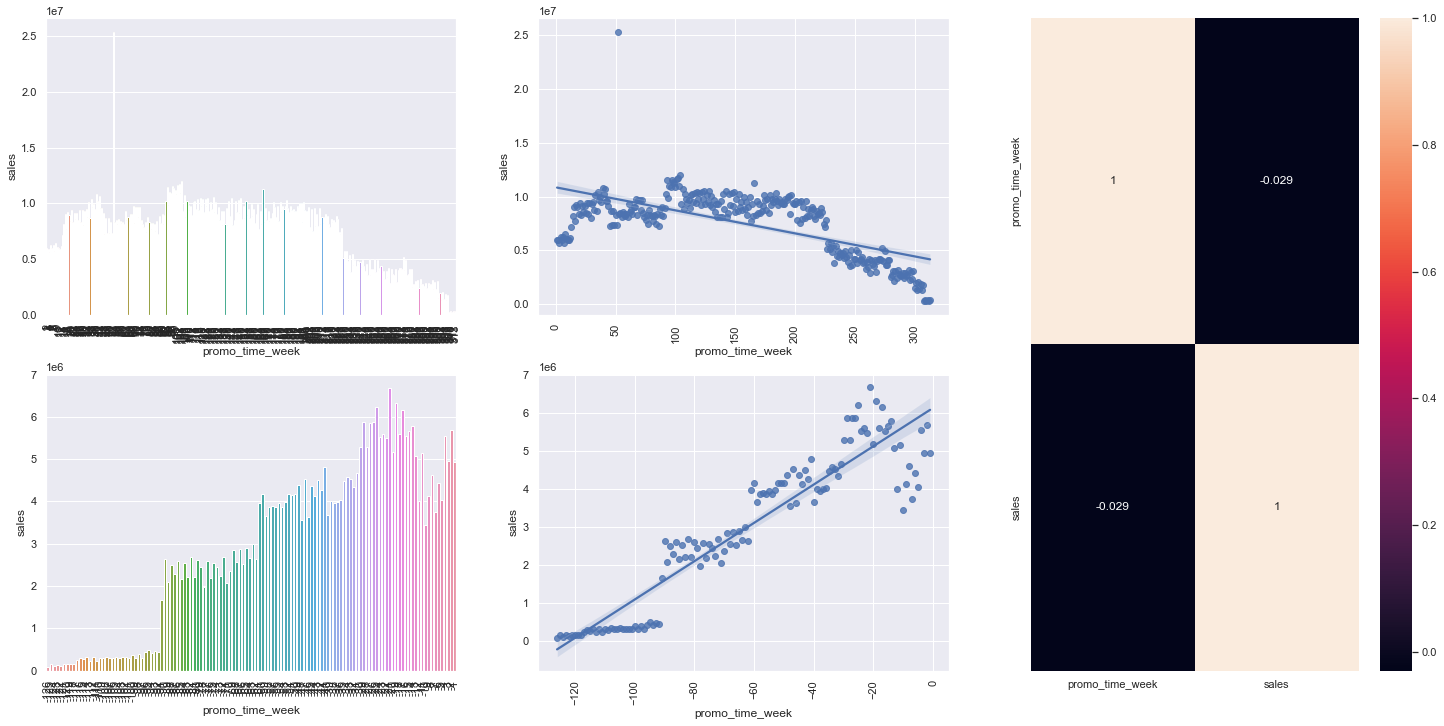

In [54]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

aux2 = aux1[aux1['promo_time_week'] > 0]
plt.subplot(grid[0,0])
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

aux3 = aux1[aux1['promo_time_week'] < 0]
plt.subplot(grid[1,0])
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr(method='pearson'),annot=True);

### <s> H5.Lojas com mais dias de promoção deveriam vender mais.</s>

### H6.Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [55]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1369694810
1,0,1,1263277463
2,1,0,1498917244
3,1,1,1440627971


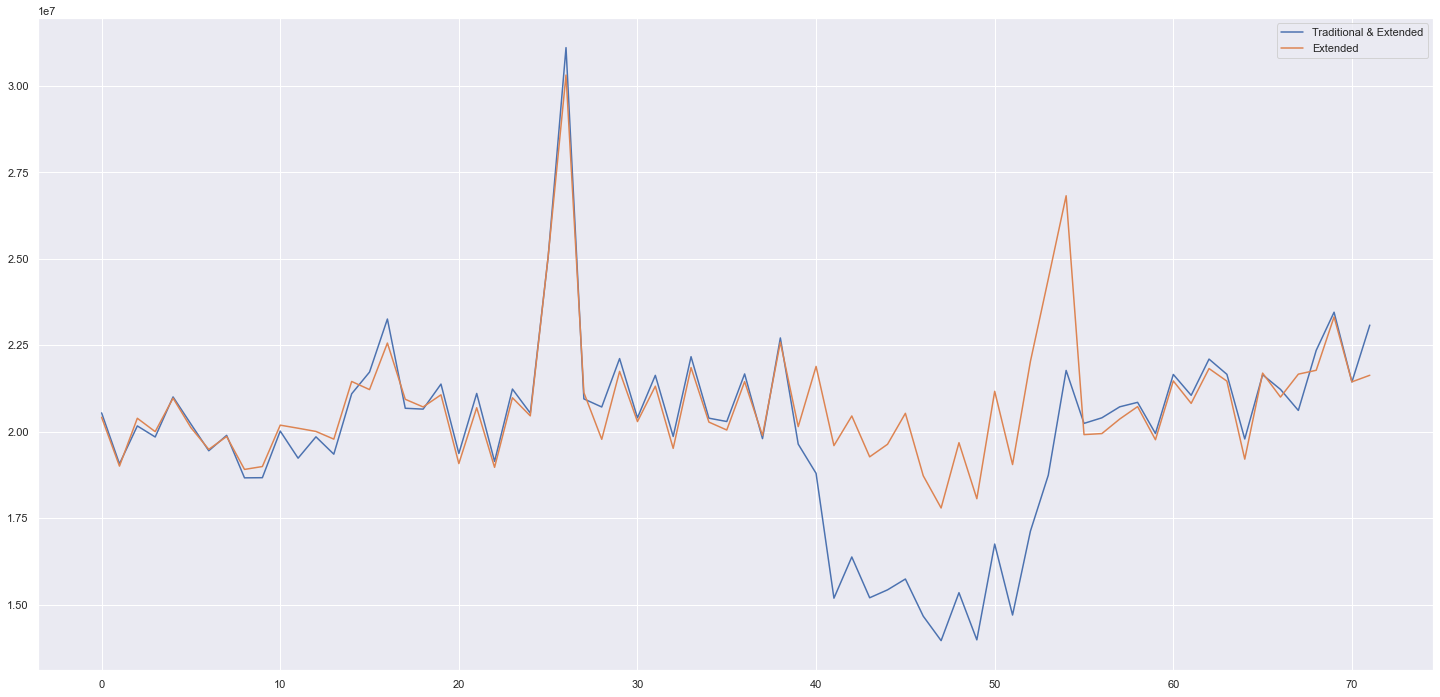

In [56]:
aux1 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1 ) & (df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend( labels=['Traditional & Extended', 'Extended']);

### H7.Lojas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

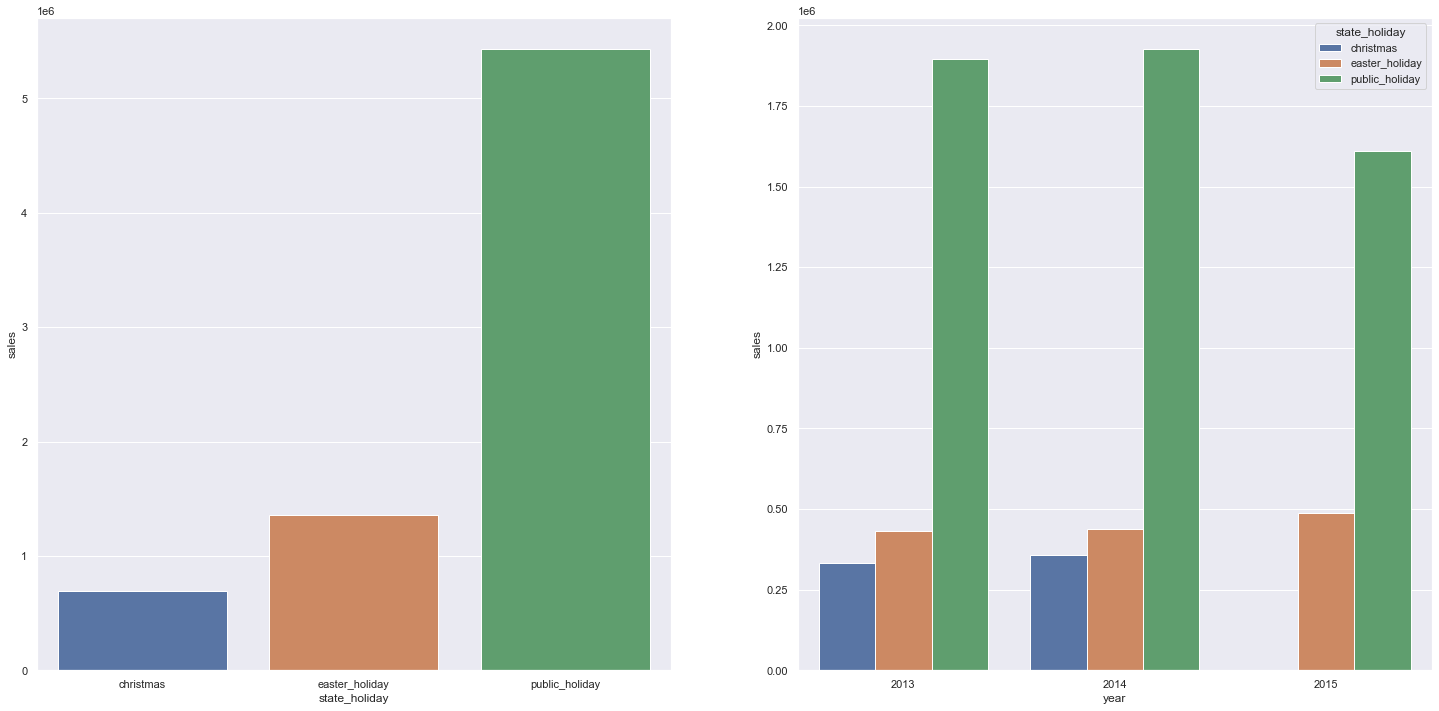

In [57]:
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday' , y='sales', data= aux1);

aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x='year' , y='sales', hue='state_holiday' ,data= aux2);

### H8.Lojasdeveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

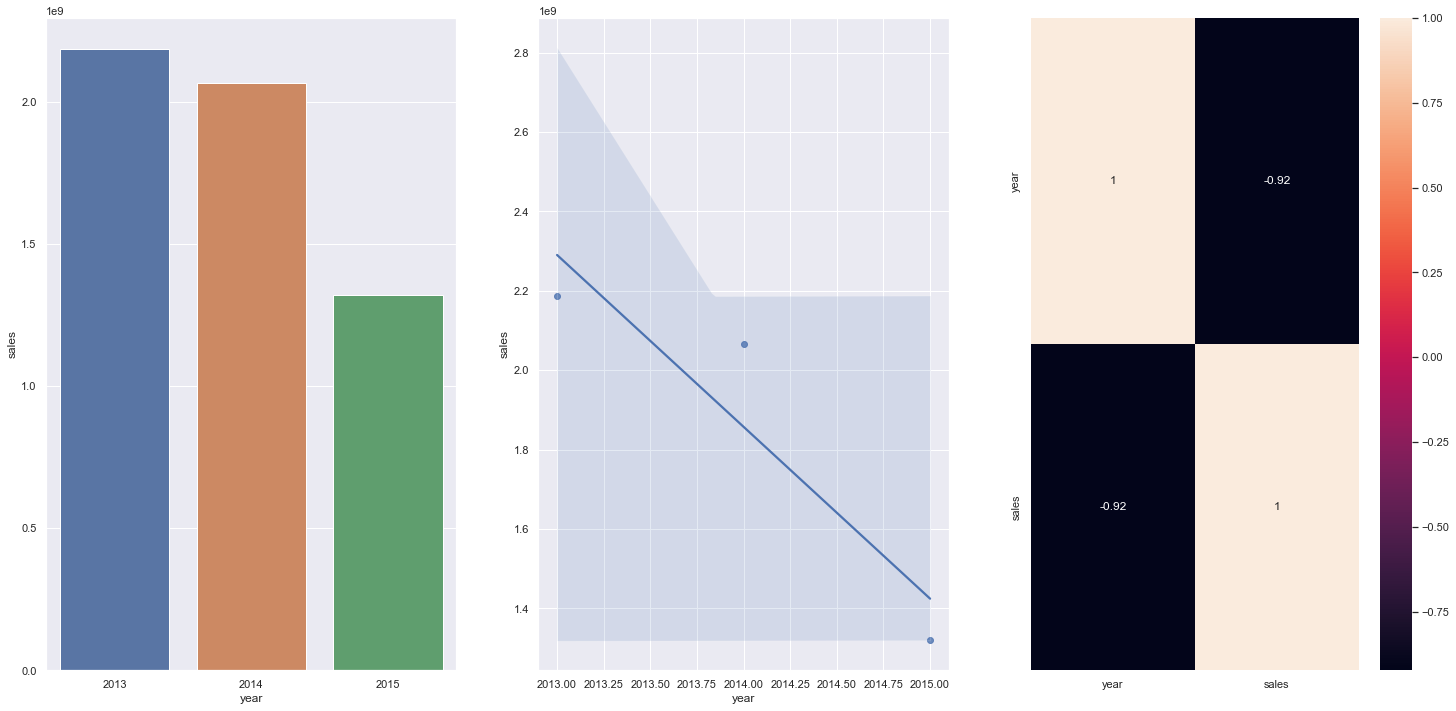

In [58]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index() #relação ao ano

plt.subplot(1,3,1)
sns.barplot(x='year' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='year' , y='sales' , data=aux1 ); #tendência

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True); #correlação

### H9.Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vedem menos no segundo semestre do ano.

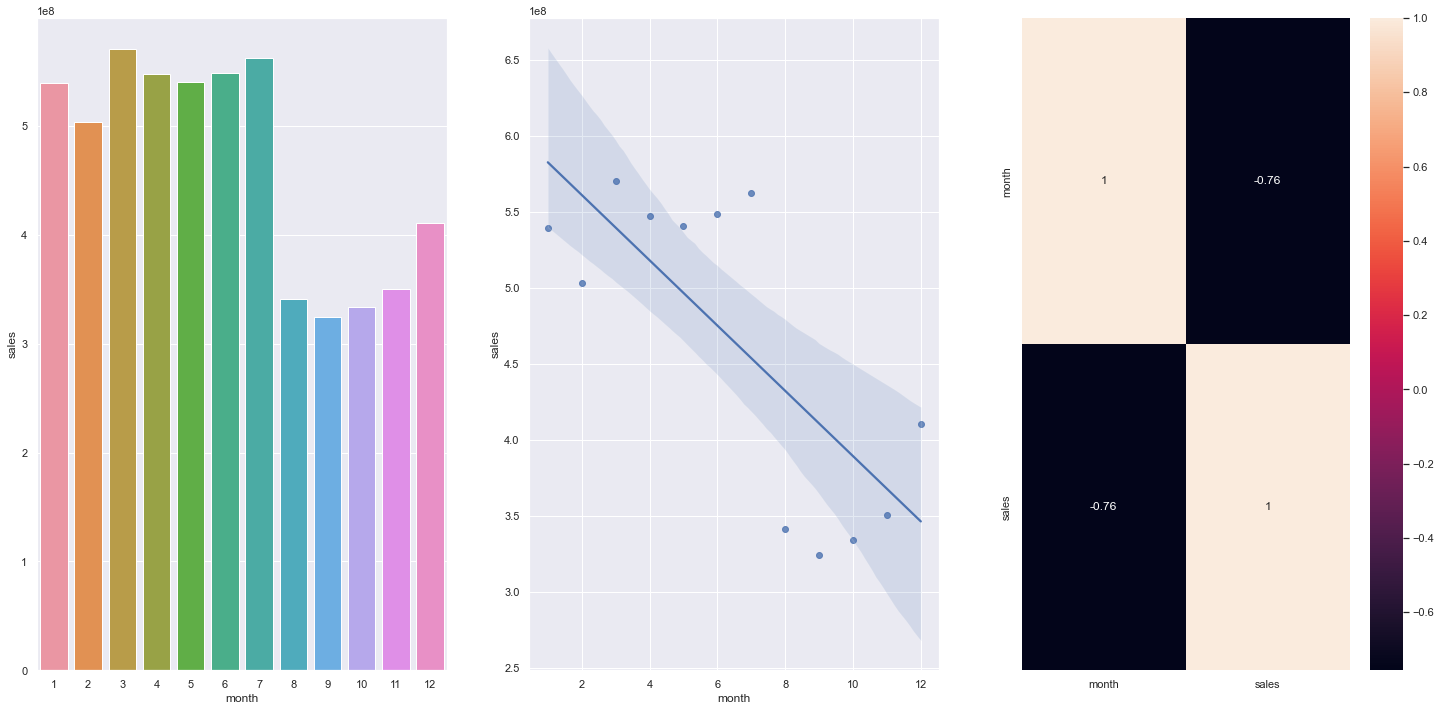

In [59]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index() #relação ao mês

plt.subplot(1,3,1)
sns.barplot(x='month' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='month' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H10.Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês. 

In [60]:
aux1.head()

,month,sales
0,1,539225694
1,2,503150192
2,3,570545191
3,4,547184971
4,5,540639286


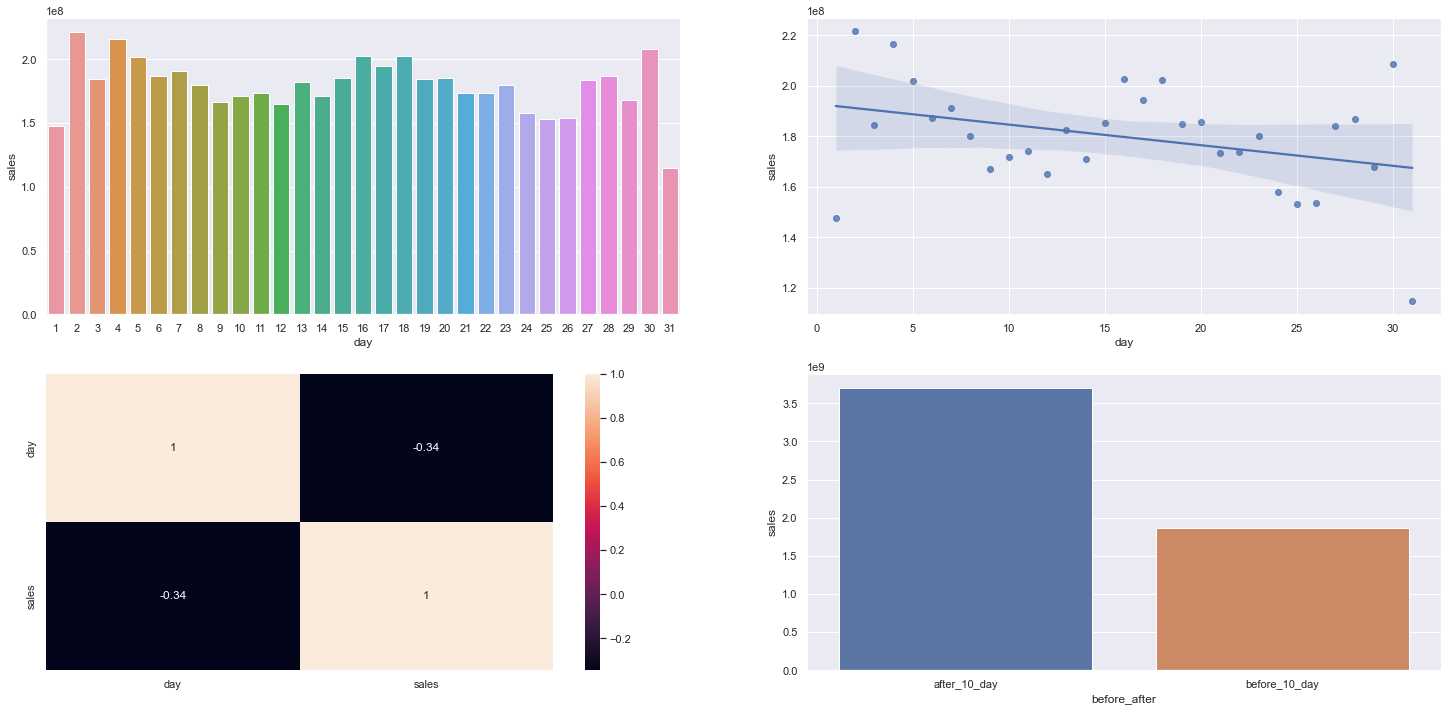

In [61]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day' , y='sales' , data=aux1 );

plt.subplot(2,2,2)
sns.regplot(x='day' , y='sales' , data=aux1 );

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after' , y='sales' , data=aux2);

### H11.Lojas deveriam vender menos nos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana.

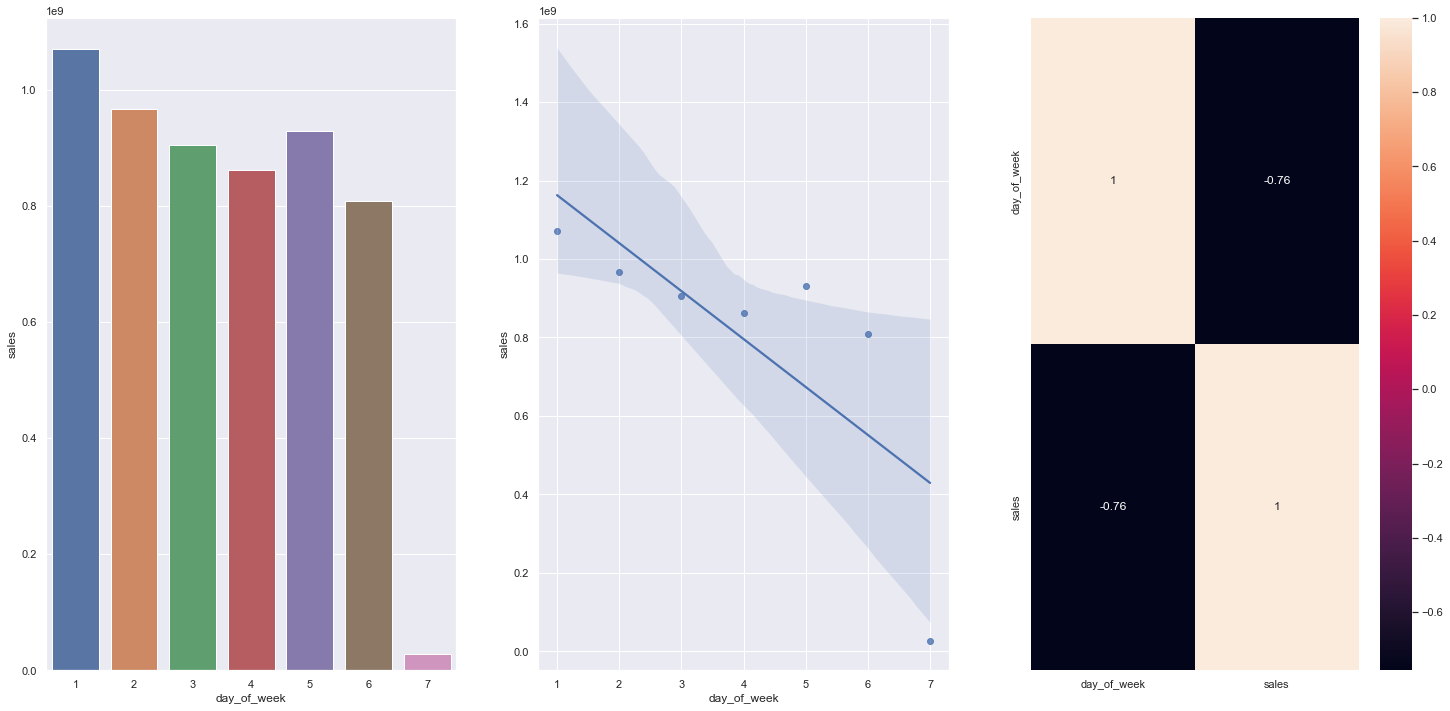

In [62]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week' , y='sales' , data=aux1 );

plt.subplot(1,3,2)
sns.regplot(x='day_of_week' , y='sales' , data=aux1 );

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson') ,annot = True);

### H12.Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

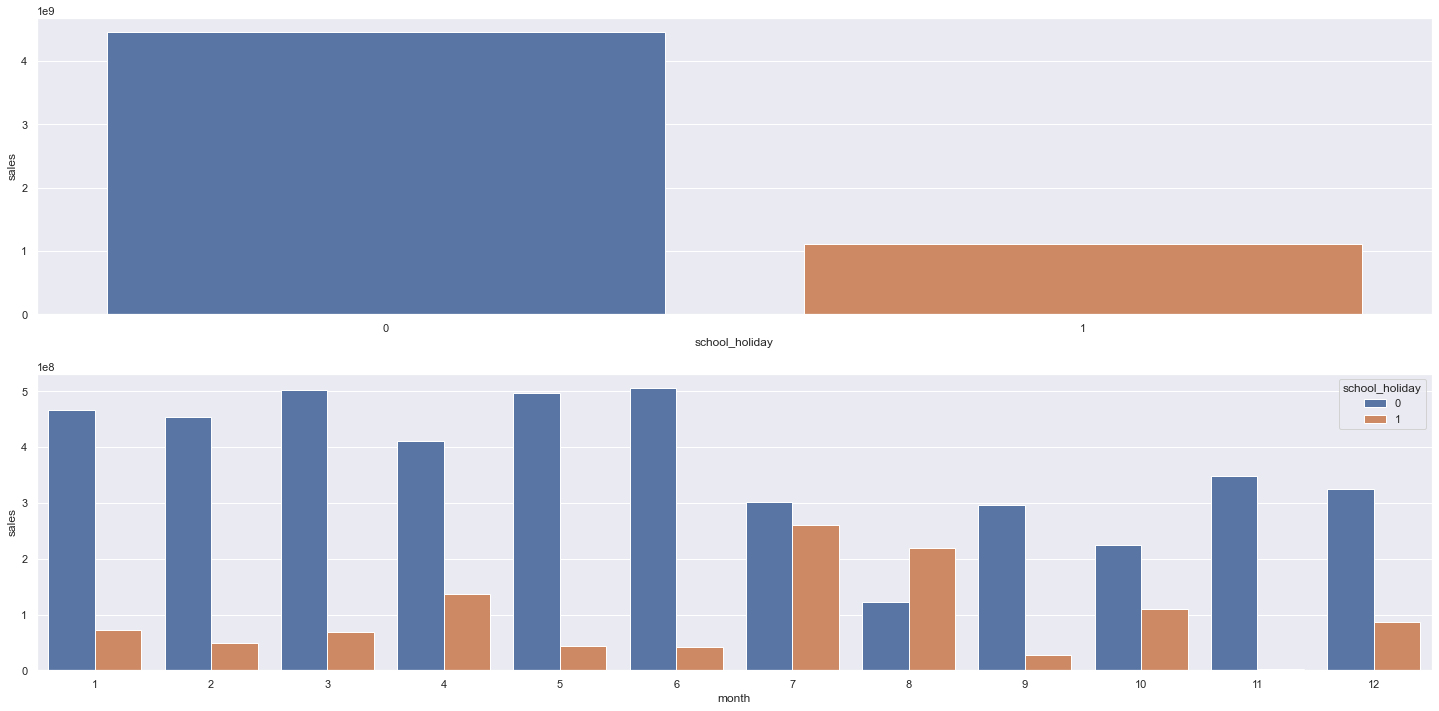

In [63]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday' , y='sales' , data=aux1 );

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month' , y='sales' , hue='school_holiday', data=aux2 );

### 4.2.1. Resumo das Hipóteses

In [64]:
from tabulate import tabulate

In [65]:
tab = [['Hypotesis', 'Conclusion', 'Relevance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Average'],
      ['H3', 'False', 'Average'],  
      ['H4', 'False', 'Low'], 
      ['H5', '-', '-'],
      ['H6', 'False', 'Low'],
      ['H7', 'False', 'Average'],
      ['H8', 'False', 'High'],
      ['H9', 'False', 'High'],
      ['H10', 'True', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low'],
      ]
print( tabulate( tab, headers='firstrow'))

Hypotesis    Conclusion    Relevance
-----------  ------------  -----------
H1           False         Low
H2           False         Average
H3           False         Average
H4           False         Low
H5           -             -
H6           False         Low
H7           False         Average
H8           False         High
H9           False         High
H10          True          High
H11          True          High
H12          True          Low


## 4.3. Análise Multivariada

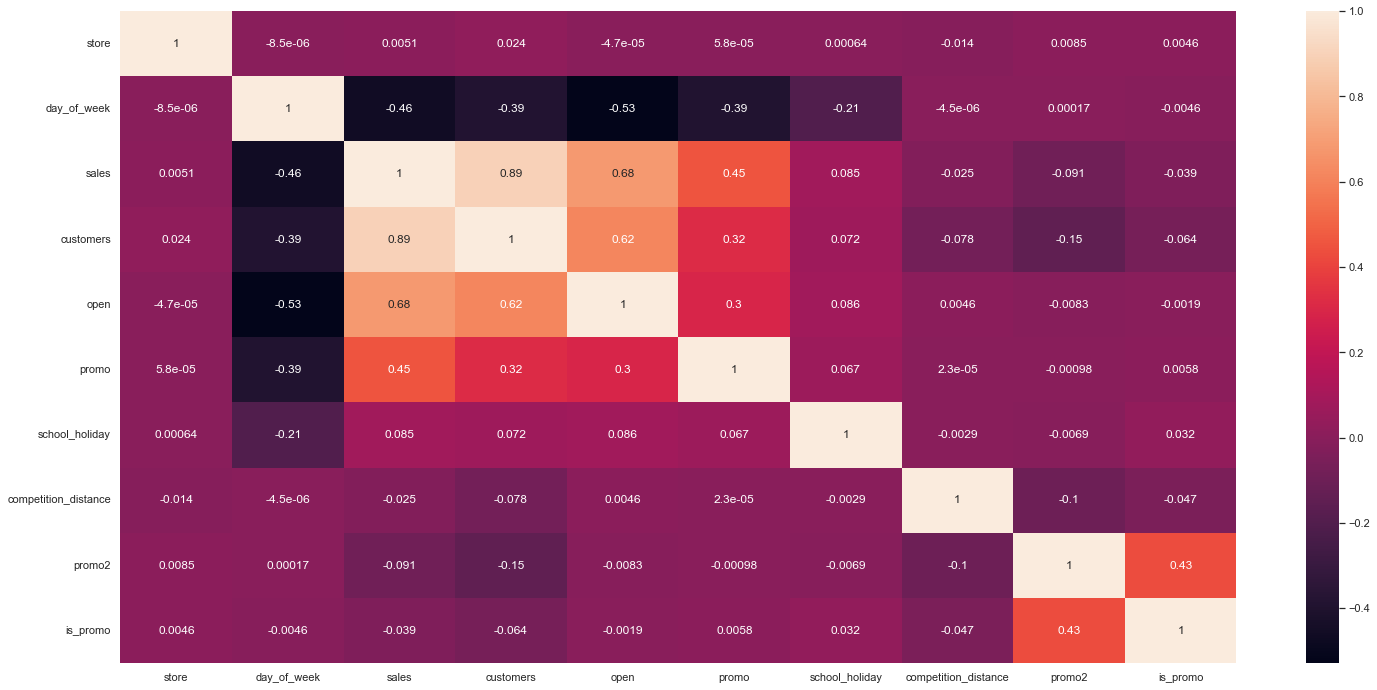

In [66]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

In [67]:
cat_attributes.head()

,state_holiday,store_type,assortment,competition_open_since_month,competition_open_since_year,promo2_since_week,promo2_since_year,promo_interval,month_map
0,0,c,a,9,2008,31,2015,0,Jul
1,0,a,a,11,2007,13,2010,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,12,2006,14,2011,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,9,2009,31,2015,0,Jul
4,0,a,a,4,2015,31,2015,0,Jul


In [68]:
a = df4.select_dtypes(include='object')

In [69]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
5,regular_day,a,basic,2015-30


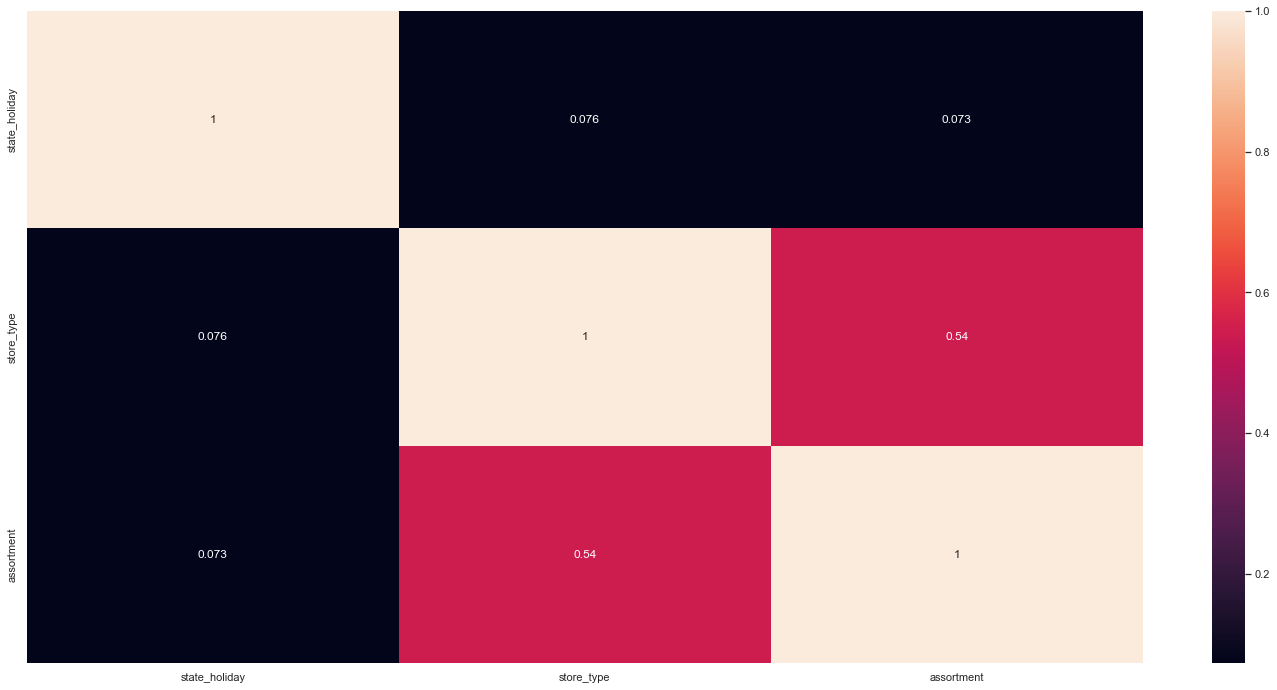

In [70]:
# only categorical data
a = df4.select_dtypes( include='object')

# calculate cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# final dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9] } )

d = d.set_index( d.columns)

sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - DATA PREPARATION

In [71]:
 df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [72]:
a = df5.select_dtypes( include=['int64', 'float64'])

In [73]:
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.00,0,0,2015,7,31,31
1,2,5,6064,1,1,570.00,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.00,1,1,2015,7,31,31
3,4,5,13995,1,1,620.00,0,0,2015,7,31,31
5,6,5,5651,1,1,310.00,0,0,2015,7,31,31


In [74]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

C:\Users\USUARIO\anaconda3\envs\Rossman_Sales_Model\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

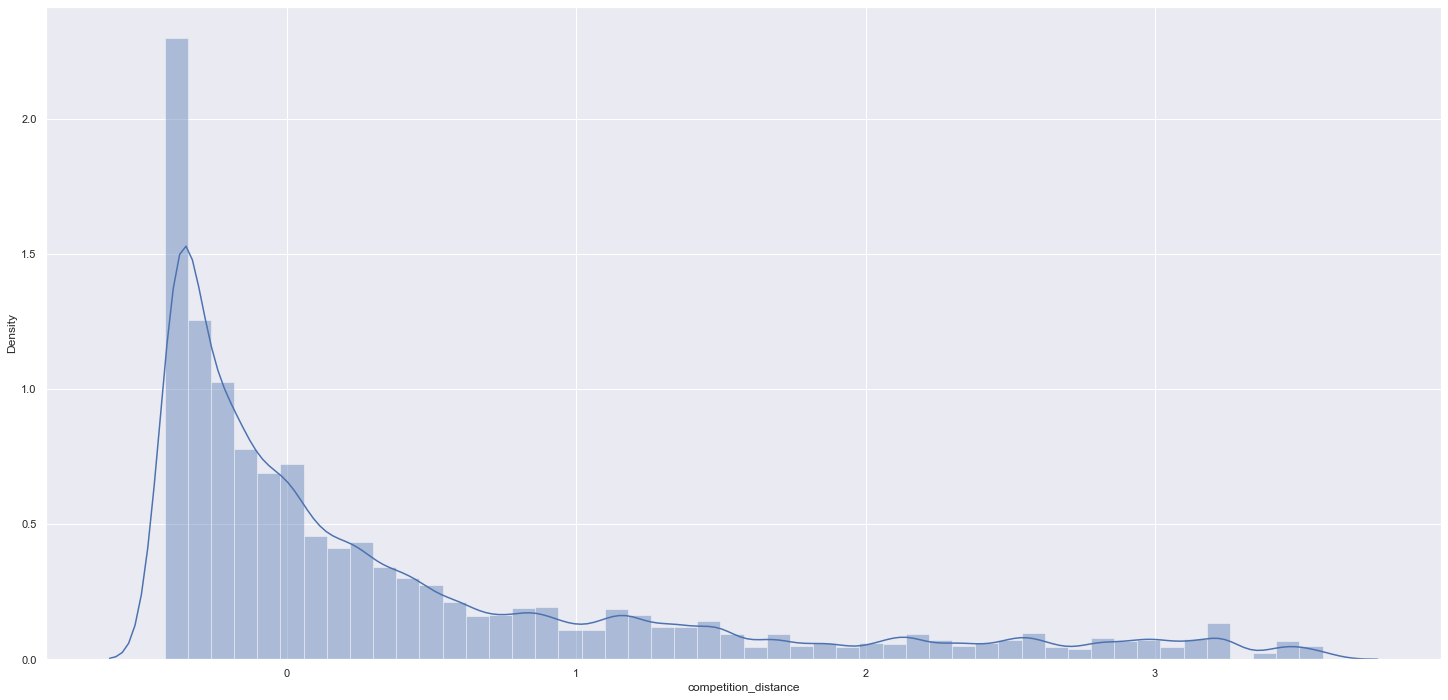

In [75]:
sns.distplot(df5['competition_distance'])

## 5.3. Transformação

### 5.3.1 Encoding

In [76]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.18,9,2008,0,31,2015,0,1.00,7,31,31,2015-30,2008-09-01,0.89,2015-07-27,0.29
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.31,11,2007,1,13,2010,1,1.00,7,31,31,2015-30,2007-11-01,1.03,2010-03-22,0.92
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,2.35,12,2006,1,14,2011,1,1.00,7,31,31,2015-30,2006-12-01,1.17,2011-03-28,0.80
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.30,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.72,2015-07-27,0.29
5,6,5,2015-07-31,5651,1,regular_day,1,a,basic,-0.37,12,2013,0,31,2015,0,1.00,7,31,31,2015-30,2013-12-01,0.04,2015-07-27,0.29


In [77]:
# state_holiday - One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

In [78]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.18,9,2008,0,31,2015,0,1.00,7,31,31,2015-30,2008-09-01,0.89,2015-07-27,0.29,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.31,11,2007,1,13,2010,1,1.00,7,31,31,2015-30,2007-11-01,1.03,2010-03-22,0.92,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,2.35,12,2006,1,14,2011,1,1.00,7,31,31,2015-30,2006-12-01,1.17,2011-03-28,0.80,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.30,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.72,2015-07-27,0.29,0,0,0,1
5,6,5,2015-07-31,5651,1,1,a,basic,-0.37,12,2013,0,31,2015,0,1.00,7,31,31,2015-30,2013-12-01,0.04,2015-07-27,0.29,0,0,0,1


In [79]:
# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.1 Response Variable Transformation

In [80]:
df5['sales'] = np.log1p( df5 ['sales'])

C:\Users\USUARIO\anaconda3\envs\Rossman_Sales_Model\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

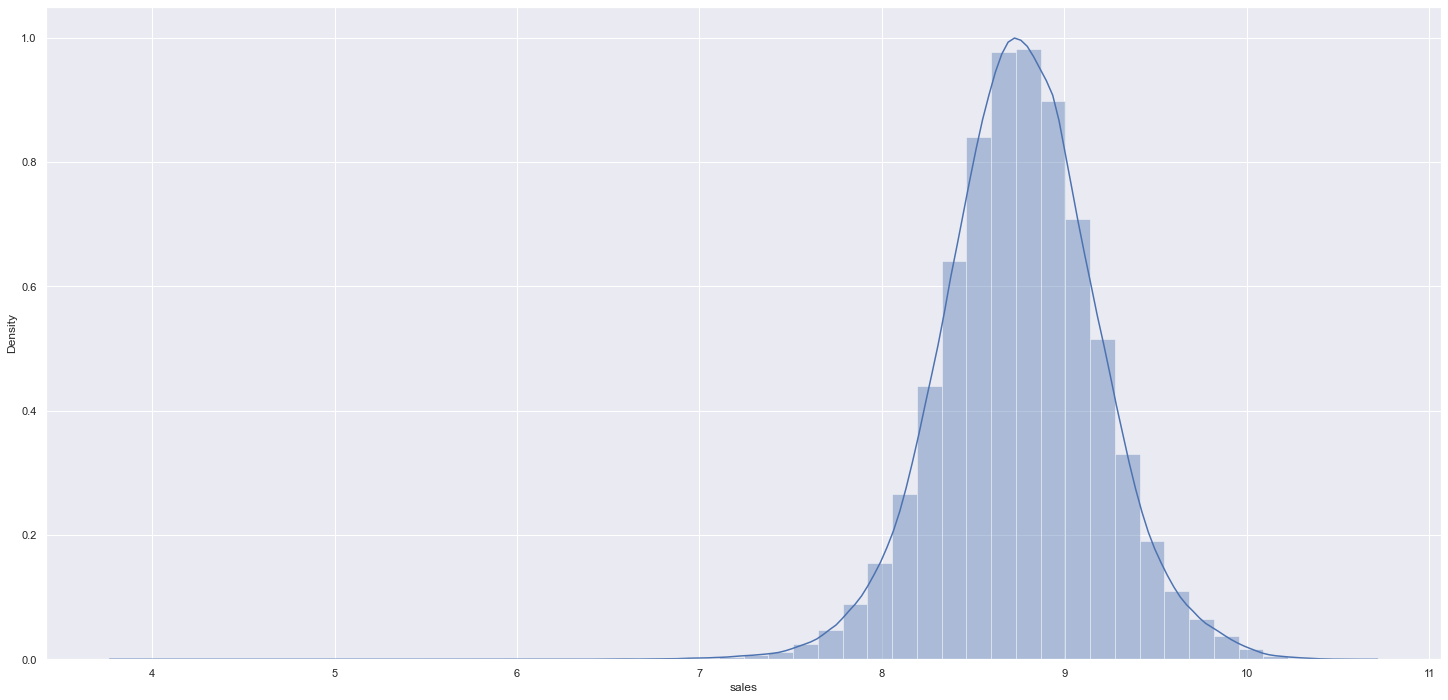

In [81]:
sns.distplot( df5['sales'])

### 5.3.1 Nature Transformation

In [82]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.57,1,1,2,1,-0.18,9,2008,0,31,2015,0,1.00,7,31,31,2015-30,2008-09-01,0.89,2015-07-27,0.29,0,0,0,1
1,2,5,2015-07-31,8.71,1,1,0,1,-0.31,11,2007,1,13,2010,1,1.00,7,31,31,2015-30,2007-11-01,1.03,2010-03-22,0.92,0,0,0,1
2,3,5,2015-07-31,9.03,1,1,0,1,2.35,12,2006,1,14,2011,1,1.00,7,31,31,2015-30,2006-12-01,1.17,2011-03-28,0.80,0,0,0,1
3,4,5,2015-07-31,9.55,1,1,2,3,-0.30,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.72,2015-07-27,0.29,0,0,0,1
5,6,5,2015-07-31,8.64,1,1,0,1,-0.37,12,2013,0,31,2015,0,1.00,7,31,31,2015-30,2013-12-01,0.04,2015-07-27,0.29,0,0,0,1


In [83]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )


# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

In [84]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.57,1,1,2,1,-0.18,9,2008,0,31,2015,0,1.00,7,31,31,2015-30,2008-09-01,0.89,2015-07-27,0.29,0,0,0,1,-0.97,-0.97,-0.50,-0.87,0.21,0.98,-0.57,-0.82
1,2,5,2015-07-31,8.71,1,1,0,1,-0.31,11,2007,1,13,2010,1,1.00,7,31,31,2015-30,2007-11-01,1.03,2010-03-22,0.92,0,0,0,1,-0.97,-0.97,-0.50,-0.87,0.21,0.98,-0.57,-0.82
2,3,5,2015-07-31,9.03,1,1,0,1,2.35,12,2006,1,14,2011,1,1.00,7,31,31,2015-30,2006-12-01,1.17,2011-03-28,0.80,0,0,0,1,-0.97,-0.97,-0.50,-0.87,0.21,0.98,-0.57,-0.82
3,4,5,2015-07-31,9.55,1,1,2,3,-0.30,9,2009,0,31,2015,0,1.00,7,31,31,2015-30,2009-09-01,0.72,2015-07-27,0.29,0,0,0,1,-0.97,-0.97,-0.50,-0.87,0.21,0.98,-0.57,-0.82
5,6,5,2015-07-31,8.64,1,1,0,1,-0.37,12,2013,0,31,2015,0,1.00,7,31,31,2015-30,2013-12-01,0.04,2015-07-27,0.29,0,0,0,1,-0.97,-0.97,-0.50,-0.87,0.21,0.98,-0.57,-0.82


# 6.0. PASSO 06 - FEATURE SELECTION

In [85]:
df6 = df5.copy()

## 5.1. Split dataframe into training and test dataset

In [86]:
# deletando variáveis que foram transformadas
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop (cols_drop , axis=1)

In [87]:
# agrupando os períodas de datas para o treino do modelo
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days =6*7 )

Timestamp('2015-06-19 00:00:00')

In [88]:
# # training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# # test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print( 'Training Min Date: {}'.format( x_train['date'].min() ) )
print( 'Training Max Date: {}'.format( x_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( x_test['date'].min() ) )
print( 'Test Max Date: {}'.format( x_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [89]:
# # training and test dataset for Boruta
# x_train_n = x_train.drop(['date','sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# # define RandomForestRegressor
# rf = RandomForestRegressor( n_jobs=-1)

# # # define Boruta
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n , y_train_n)

### 6.2.1. Best Features from Boruta

In [90]:
# cols_selected = boruta.support_.tolist()

# # # best features
# x_train_fs = x_train.drop(['date','sales'], axis=1)
# cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# # # not selected boruta
# cols_not_selected = np.setdiff1d(x_train_fs.columns, cols_selected_boruta)

## 6.4. Manual Feature Selection

In [91]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# columns to add
feat_to_add = ['date','sales']

#final features
# cols_selected_boruta.extend( feat_to_add)

In [92]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

In [93]:
X_train = x_train[ cols_selected_boruta]
X_test = x_test[ cols_selected_boruta]

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [163]:
X_train = x_train[ cols_selected_boruta]
X_test = x_test[ cols_selected_boruta]

## 7.1. Average Model

In [164]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store' , 'sales']].groupby( 'store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge( aux1, aux2 , how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1338.69,0.45,1811.20


## 7.2. Linear Regression Model

In [181]:
# model
#lr = LinearRegression().fit( x_train, y_train )

# prediction
#yhat_lr = lr.predict( x_test )

# performance
#lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
#lr_result

## 7.3. Linear Regression Regularized Model

In [180]:
# model
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train)

# prediction
yhat_lrr = lrr.predict( X_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test) , np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1893.11,0.29,2754.41


### 7.3.1 Linear Regression Model - Cross Validation

In [159]:
#lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
#lr_result_cv

## 7.4. Random Forest Regressor

In [130]:
# model
# rf = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

# # prediction
# yhat_rf = rf.predict( x_test )

# performance
# rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test) , np.expm1(yhat_rf) )
# rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [131]:
# rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
# rf_result_cv

## 7.5.  XGBoost Regressor

In [132]:
# # model
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                              n_estimators=100,
#                              eta=0.01,
#                              max_depth=10,
#                              subsample=0.7,
#                              colsample_bytree=0.9 ).fit( x_train, y_train)      

# # prediction
# yhat_xgb = model_xgb.predict( x_test )

# # performance
# xgb_result = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(yhat_xgb) )
# xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [133]:
# xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# xgb_result_cv

## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [160]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

NameError: name 'rf_result' is not defined

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

# 8.1 Random Search

In [135]:
# param = {
#       'n_estimators': [1500, 1700, 2500, 3000, 3500],
#       'eta': [0.01 , 0.03],
#       'max_depth': [3, 5, 9],
#       'subsample': [0.1, 0.5, 0.7],
#       'colsample_bytree': [0.3, 0.7, 0.9],
#       'min_child_weight': [3, 8, 15] 
#        }

# MAX_EVAL = 10

In [136]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: random.sample( v, 1)[0]for k, v in param.items() }
#     print( hp )
    
#     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['colsample_bytree'],
#                                  min_child_weight=hp['min_child_weight'] )
    
#     # performance
#     result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False )
#     final_result = pd.concat([final_result, result])
    
# final_result

# 8.2 Final Model

In [137]:
param_tuned = {
      'n_estimators':2500 ,
      'eta': 0.01 ,
      'max_depth': 9,
      'subsample':0.5 ,
      'colsample_bytree':0.3 ,
      'min_child_weight':8 
       }

In [154]:
# model
#model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytree=param_tuned['colsample_bytree'],
                                   min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train)   
    
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
#xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1(y_test) , np.expm1(yhat_xgb_tuned) )
#xgb_result_tuned

IndentationError: unexpected indent (3723937700.py, line 3)

# 9.0 PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [156]:
df9 = X_test[ cols_selected_boruta_full ]
# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

NameError: name 'cols_selected_boruta_full' is not defined